https://www.kaggle.com/c/nlp-getting-started

In [1]:
#%% Import packages
import os, sys

import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, \
                            f1_score
from sklearn.pipeline import FeatureUnion
    
from sklearn.naive_bayes import MultinomialNB

from matplotlib import pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from IPython import display

In [2]:
# adding custom path for importing custom defs
module_path = os.path.abspath(os.path.join('..', '..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
#%% Import custom packages
from my_defs.model import *
from my_defs.text import *

In [4]:
#%% Import Datasets
train_df = pd.read_csv('../input_data/train.csv')
test_df = pd.read_csv('../input_data/test.csv')
submission_df = pd.read_csv('../input_data/sample_submission.csv')

0    0.57034
1    0.42966
Name: target, dtype: float64


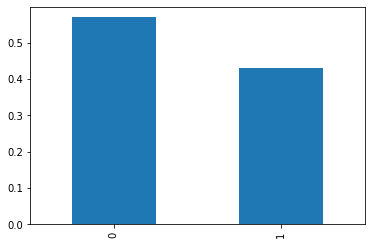

In [5]:
print(train_df['target'].value_counts(normalize=True))
train_df['target'].value_counts(normalize=True).plot(kind='bar');

In [6]:
#%%
# text processing
train_df['text_processed'] = text_cleanup(train_df['text'])

In [7]:
#%% Test train split
X_train, X_test, y_train, y_test = \
    train_test_split(train_df['text_processed'], train_df['target'], \
                     test_size=0.25, random_state=33)

In [8]:
#%%
# Count vectoriser --> Multinomial NB
pipeline = Pipeline([('vectorizer', CountVectorizer()), ('classifier', MultinomialNB())])
nb_count = train(pipeline, X_train, y_train, X_test, y_test, score_training_data=True)

#test_df['target'] = clf.predict(text_cleanup(test_df['text']))
#test_df[['id', 'target']].to_csv('../submissions/submission_naivebayes.csv', \
#                                 index=False)

   Accuracy  Precision     Recall         F1
--------------------------------------------
    0.90173    0.92079    0.84163    0.87943 <-- train
    0.77363    0.78052    0.67738    0.72530  <-- test


In [9]:
#%%
# Tfidf vectoriser --> Multinomial NB
pipeline = Pipeline([('vectorizer', TfidfVectorizer()), ('classifier', MultinomialNB())])
nb_tfidf = train(pipeline, X_train, y_train, X_test, y_test, score_training_data=True)

   Accuracy  Precision     Recall         F1
--------------------------------------------
    0.88877    0.95262    0.77746    0.85617 <-- train
    0.77206    0.82637    0.61190    0.70315  <-- test


In [10]:
#%%
# Count vectoriser --> SVM
pipeline = Pipeline([('vectorizer', CountVectorizer()), ('classifier', SVC(probability=True))])
svc_count = train(pipeline, X_train, y_train, X_test, y_test, score_training_data=True)



   Accuracy  Precision     Recall         F1
--------------------------------------------
    0.94255    0.97904    0.88400    0.92910 <-- train
    0.78571    0.85644    0.61786    0.71784  <-- test


In [12]:
test_df['target'] = svc_count.predict(text_cleanup(test_df['text']))
test_df[['id', 'target']].to_csv('../submissions/submission_svm.csv', \
                                 index=False)

In [13]:
train_df['tfidf_naivebayes'] = nb_tfidf.predict_proba(train_df['text_processed'])[:, 0]
train_df['count_naivebayes'] = nb_count.predict_proba(train_df['text_processed'])[:, 0]
train_df['count_svm'] = svc_count.predict_proba(train_df['text_processed'])[:, 0]
train_df['keyword_present'] = train_df['keyword'].notnull()
train_df['location_present'] = train_df['location'].notnull()

In [18]:
cols = ['tfidf_naivebayes', 'count_naivebayes', 'count_svm', 'keyword_present', 'location_present']

X1_train, X1_test, y1_train, y1_test = \
    train_test_split(train_df[cols], train_df['target'], \
                     test_size=0.25, random_state=33)


clf_final = RandomForestClassifier(n_estimators=500)

clf_final = train(clf_final, X1_train, y1_train, X1_test, y1_test, score_training_data=True)
train_df['pred_target'] = clf_final.predict(train_df[cols])

   Accuracy  Precision     Recall         F1
--------------------------------------------
    0.99194    0.99175    0.98930    0.99053 <-- train
    0.74737    0.69967    0.74881    0.72340  <-- test


In [14]:
train_df['pred_target'] = nb_count.predict(train_df['text_processed'])
for i, r in train_df[train_df['pred_target'] != train_df['target']][['id', 'text', 'text_processed', 'target', 'pred_target']].sample(5).iterrows():
    print(r['text'])
    print(r['text_processed'])
    print(r['target'], r['pred_target'])
    print('-------------------------------------------')

Destruction magic's fine just don't go burning down any buildings.
destruction magic s fine go burning building
1 0
-------------------------------------------
Angry Woman Openly Accuses NEMA Of Stealing Relief Materials Meant For IDPs: An angry Internally Displaced wom... http://t.co/6ySbCSSzYS
angry woman openly accuses nema stealing relief material meant idps: angry internally displaced wom link
0 1
-------------------------------------------
@ictyosaur I never thought it would be a wtf moment yet it's here after months of 90 degree heat
Next we will have flash floods..
taggedword never thought would wtf moment yet month 90 degree heat next flash flood
1 0
-------------------------------------------
Wed 20:30: Mainly cloudy. 60 percent chance of showers this evening with risk of a thunderstorm. Low 10.
wed 20:30: mainly cloudy 60 percent chance shower evening risk thunderstorm low 10
0 1
-------------------------------------------
@rvfriedmann Hell is just a fraction of his belief o

In [15]:
train_df['keyword'].unique()

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'der

'Well said Sir. My cousin was a POW. Brutally treated. Survived but never talked about it. The bombing was justified  link '